In [38]:
import numpy as np
from qiskit.algorithms.time_evolvers.variational.var_qite import VarQITE
from qiskit.algorithms.time_evolvers.time_evolution_problem import TimeEvolutionProblem
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import algorithm_globals
from qiskit.primitives import Estimator
from qiskit.algorithms.time_evolvers.variational import (
    ImaginaryMcLachlanPrinciple,
)
from scipy.sparse.linalg import expm_multiply
from qiskit.primitives import Sampler

from qiskit.algorithms.gradients import LinCombQFI, LinCombEstimatorGradient

from qiskit.quantum_info import partial_trace

from qiskit.algorithms.gibbs_state_preparation.default_ansatz_builder import build_ansatz, build_init_ansatz_params_vals

from qiskit.algorithms.gibbs_state_preparation.varqite_gibbs_state_builder import VarQiteGibbsStateBuilder
from qiskit.visualization import plot_histogram

hamiltonian = SparsePauliOp.from_list([("ZZ",1.0)])
ansatz = build_ansatz(2*hamiltonian.num_qubits,1)
init_param_values = build_init_ansatz_params_vals(2*hamiltonian.num_qubits,1)
init_statevector = Statevector(ansatz.assign_parameters(init_param_values,inplace=False))
algorithm_globals.random_seed = 123
estimator = Estimator()
qfi = LinCombQFI(estimator)
gradient = LinCombEstimatorGradient(estimator)
var_principle = ImaginaryMcLachlanPrinciple(qfi, gradient)

var_qite = VarQITE(
    ansatz=ansatz,
    initial_parameters = init_param_values,
    variational_principle = var_principle,
    estimator = estimator,
    num_timesteps=20,
)

BOLTZMANN_CONSTANT = 1.38064852e-2
beta = 40
temperature = 1/(BOLTZMANN_CONSTANT*beta)

param_dict = dict(zip(ansatz.parameters, init_param_values))
sampler  = Sampler()
gibbs_state_builder = VarQiteGibbsStateBuilder(sampler, var_qite,ansatz,param_dict)
gibbs_state = gibbs_state_builder.build(hamiltonian, temperature=temperature, problem_hamiltonian_param_dict = param_dict)


final_circuit = gibbs_state.gibbs_state_function.copy()
qr = final_circuit.qregs[0]
non_aux_registers = int(len(qr) / 2)
new_creg = final_circuit._create_creg(non_aux_registers, "meas")
final_circuit.add_register(new_creg)
final_circuit.barrier()
for i in range(non_aux_registers):
    final_circuit.measure(qr[i], new_creg[i])


Instruction(name='EfficientSU2', num_qubits=4, num_clbits=0, params=[ParameterExpression(6.78285365764887e-16), ParameterExpression(-1.33934991115378), ParameterExpression(3.58464211576547e-17), ParameterExpression(3.92591625219366e-17), ParameterExpression(-5.09449023009915e-16), ParameterExpression(2.31319035882162e-16), ParameterExpression(-2.07984474907694e-16), ParameterExpression(-5.25872347652854e-16), ParameterExpression(1.5707963267949), ParameterExpression(1.5707963267949), ParameterExpression(1.36104934946488e-16), ParameterExpression(8.78794391616814e-16), ParameterExpression(-1.56889404600833e-15), ParameterExpression(-9.01495231048047e-16), ParameterExpression(-3.56138426361195e-16), ParameterExpression(-3.88539977692513e-16)])


In [39]:
qite_mixed_state = partial_trace(Statevector(gibbs_state.gibbs_state_function),list(range(0,hamiltonian.num_qubits)))
print(qite_mixed_state.probabilities())

[0.00666609 0.49333391 0.49333391 0.00666609]


In [40]:
sampler = Sampler()
probs = sampler.run(final_circuit,shots=1000)
print("Sampled Results")
print(probs.result())

Sampled Results
SamplerResult(quasi_dists=[{0: 0.008, 1: 0.494, 2: 0.493, 3: 0.005}], metadata=[{'shots': 1000}])


In [41]:

hamiltonian_extended = hamiltonian^("I"*hamiltonian.num_qubits)
theoretical_final_state = expm_multiply(-hamiltonian_extended.to_matrix(sparse=True)*beta/2,init_statevector.data)
theoretical_final_state = theoretical_final_state/np.linalg.norm(theoretical_final_state)
theoretical_final_state = partial_trace(Statevector(theoretical_final_state),list(range(0,hamiltonian.num_qubits)))
print(theoretical_final_state.probabilities())

[9.02425694e-36 5.00000000e-01 5.00000000e-01 9.02425694e-36]


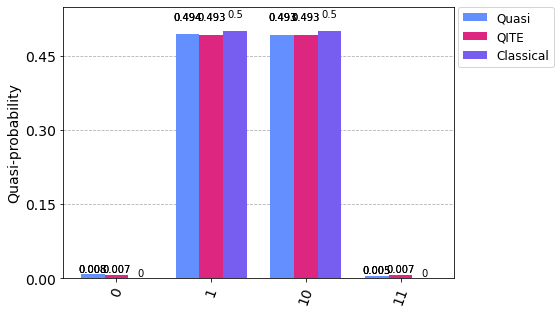

In [42]:
classical = {"{0:b}".format(n) : p for n,p in enumerate(theoretical_final_state.probabilities())}
quasi_dist = {"{0:b}".format(n) : p for n,p in enumerate(probs.result().quasi_dists[0].values())}
qite_dist = {"{0:b}".format(n) : p for n,p in enumerate(qite_mixed_state.probabilities())}
plot_histogram([quasi_dist,qite_dist,classical],legend=["Quasi","QITE","Classical"])